In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import scipy
from warnings import filterwarnings
from xgboost import XGBClassifier
import datetime as dt

In [2]:
filterwarnings('ignore')
data = pd.read_csv('Datasets/HCP.csv')

In [3]:
data

,patientid,age,gender,department,diagnosis,admissiondate,dischargedate,treatmentcost,doctorname,readmitted,city,severity,insuranceprovider,treatmenttype,bedtype,paymentmethod,satisfactionscore,length_of_stay,age_group
0,P0001,38,Male,Orthopedics,Fracture,2024-01-19,2024-01-30,89503,Dr. Mehta,Yes,Kolkata,Moderate,LIC Health,Surgery,General,Insurance,3,11,Adult (18-64)
1,P0002,57,Male,Pediatrics,Asthma,2024-07-01,2024-07-06,23659,Dr. Banerjee,Yes,Chennai,Severe,Star Health,Observation,Private,Online,1,5,Adult (18-64)
2,P0003,32,Female,Neurology,Stroke,2024-02-19,2024-03-04,316652,Dr. Iyer,Yes,Delhi,Mild,Star Health,Observation,General,Cash,6,14,Adult (18-64)
3,P0004,22,Male,Orthopedics,Joint Replacement,2024-03-05,2024-03-10,74980,Dr. Singh,Yes,Chennai,Mild,ICICI Lombard,Therapy,Semi-Private,Credit Card,9,5,Adult (18-64)
4,P0005,46,Female,Pediatrics,Asthma,2024-05-03,2024-05-08,92331,Dr. Iyer,Yes,Mumbai,Moderate,ICICI Lombard,Surgery,ICU,Credit Card,8,5,Adult (18-64)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P0996,88,Female,Cardiology,Arrhythmia,2025-07-28,2025-08-05,77977,Dr. Sharma,No,Hyderabad,Moderate,LIC Health,Medication,General,Cash,7,8,Senior (65+)
996,P0997,66,Male,Orthopedics,Joint Replacement,2024-01-16,2024-01-25,141590,Dr. Banerjee,Yes,Chennai,Severe,LIC Health,Observation,General,Credit Card,7,9,Senior (65+)
997,P0998,12,Female,General Surgery,Gallstones,2024-07-27,2024-08-10,143001,Dr. Banerjee,No,Mumbai,Severe,HDFC Ergo,Therapy,Private,Credit Card,7,14,Pediatric (0-17)
998,P0999,12,Male,Neurology,Migraine,2024-06-10,2024-06-12,227324,Dr. Khan,Yes,Bengaluru,Severe,New India Assurance,Surgery,General,Insurance,6,2,Pediatric (0-17)


In [4]:
data.columns

Index(['patientid', 'age', 'gender', 'department', 'diagnosis',
       'admissiondate', 'dischargedate', 'treatmentcost', 'doctorname',
       'readmitted', 'city', 'severity', 'insuranceprovider', 'treatmenttype',
       'bedtype', 'paymentmethod', 'satisfactionscore', 'length_of_stay',
       'age_group'],
      dtype='object')

In [5]:
dt = data.dtypes
dt = dt[dt == 'object']
dt

patientid            object
gender               object
department           object
diagnosis            object
admissiondate        object
dischargedate        object
doctorname           object
readmitted           object
city                 object
severity             object
insuranceprovider    object
treatmenttype        object
bedtype              object
paymentmethod        object
age_group            object
dtype: object

In [6]:
data.isna().sum()

patientid            0
age                  0
gender               0
department           0
diagnosis            0
admissiondate        0
dischargedate        0
treatmentcost        0
doctorname           0
readmitted           0
city                 0
severity             0
insuranceprovider    0
treatmenttype        0
bedtype              0
paymentmethod        0
satisfactionscore    0
length_of_stay       0
age_group            0
dtype: int64

In [7]:
le = LabelEncoder()

data['gender'] = le.fit_transform(data['gender'])
data['department'] = le.fit_transform(data['department'])
data['diagnosis'] = le.fit_transform(data['diagnosis'])
data['readmitted'] = le.fit_transform(data['readmitted'])
data['severity'] = le.fit_transform(data['severity'])
data['insuranceprovider'] = le.fit_transform(data['insuranceprovider'])
data['treatmenttype'] = le.fit_transform(data['treatmenttype'])
data['bedtype'] = le.fit_transform(data['bedtype'])
data['paymentmethod'] = le.fit_transform(data['paymentmethod'])
data['age_group'] = le.fit_transform(data['age_group'])
data['city'] = le.fit_transform(data['city'])

data

,patientid,age,gender,department,diagnosis,admissiondate,dischargedate,treatmentcost,doctorname,readmitted,city,severity,insuranceprovider,treatmenttype,bedtype,paymentmethod,satisfactionscore,length_of_stay,age_group
0,P0001,38,1,4,7,2024-01-19,2024-01-30,89503,Dr. Mehta,1,4,1,2,2,0,2,3,11,0
1,P0002,57,1,5,3,2024-07-01,2024-07-06,23659,Dr. Banerjee,1,1,2,4,1,2,3,1,5,0
2,P0003,32,0,2,17,2024-02-19,2024-03-04,316652,Dr. Iyer,1,2,0,4,1,0,0,6,14,0
3,P0004,22,1,4,12,2024-03-05,2024-03-10,74980,Dr. Singh,1,1,0,1,3,3,1,9,5,0
4,P0005,46,0,5,3,2024-05-03,2024-05-08,92331,Dr. Iyer,1,5,1,1,2,1,1,8,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P0996,88,0,0,1,2025-07-28,2025-08-05,77977,Dr. Sharma,0,3,1,2,0,0,0,7,8,2
996,P0997,66,1,4,12,2024-01-16,2024-01-25,141590,Dr. Banerjee,1,1,2,2,1,0,1,7,9,2
997,P0998,12,0,1,8,2024-07-27,2024-08-10,143001,Dr. Banerjee,0,5,2,0,3,2,1,7,14,1
998,P0999,12,1,2,15,2024-06-10,2024-06-12,227324,Dr. Khan,1,0,2,3,2,0,2,6,2,1


In [8]:
data.dtypes

patientid            object
age                   int64
gender                int64
department            int64
diagnosis             int64
admissiondate        object
dischargedate        object
treatmentcost         int64
doctorname           object
readmitted            int64
city                  int64
severity              int64
insuranceprovider     int64
treatmenttype         int64
bedtype               int64
paymentmethod         int64
satisfactionscore     int64
length_of_stay        int64
age_group             int64
dtype: object

In [9]:
data['admissiondate'] = pd.to_datetime(data['admissiondate'])
data['dischargedate'] = pd.to_datetime(data['dischargedate'])
data

,patientid,age,gender,department,diagnosis,admissiondate,dischargedate,treatmentcost,doctorname,readmitted,city,severity,insuranceprovider,treatmenttype,bedtype,paymentmethod,satisfactionscore,length_of_stay,age_group
0,P0001,38,1,4,7,2024-01-19,2024-01-30,89503,Dr. Mehta,1,4,1,2,2,0,2,3,11,0
1,P0002,57,1,5,3,2024-07-01,2024-07-06,23659,Dr. Banerjee,1,1,2,4,1,2,3,1,5,0
2,P0003,32,0,2,17,2024-02-19,2024-03-04,316652,Dr. Iyer,1,2,0,4,1,0,0,6,14,0
3,P0004,22,1,4,12,2024-03-05,2024-03-10,74980,Dr. Singh,1,1,0,1,3,3,1,9,5,0
4,P0005,46,0,5,3,2024-05-03,2024-05-08,92331,Dr. Iyer,1,5,1,1,2,1,1,8,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P0996,88,0,0,1,2025-07-28,2025-08-05,77977,Dr. Sharma,0,3,1,2,0,0,0,7,8,2
996,P0997,66,1,4,12,2024-01-16,2024-01-25,141590,Dr. Banerjee,1,1,2,2,1,0,1,7,9,2
997,P0998,12,0,1,8,2024-07-27,2024-08-10,143001,Dr. Banerjee,0,5,2,0,3,2,1,7,14,1
998,P0999,12,1,2,15,2024-06-10,2024-06-12,227324,Dr. Khan,1,0,2,3,2,0,2,6,2,1


In [10]:
data = data.drop(columns=['patientid', 'admissiondate', 'dischargedate', 'doctorname'])

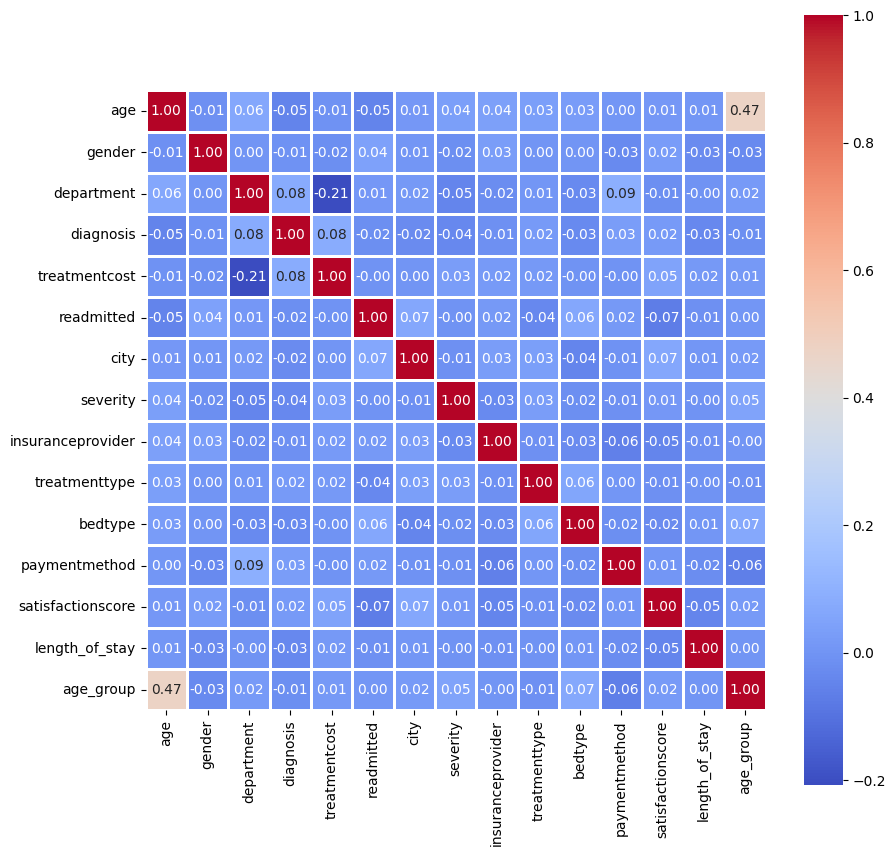

In [11]:
cor = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(cor, linewidths=1, cmap='coolwarm', annot=True, square=True, fmt='0.2f')
plt.show()

In [12]:
X = data.drop(columns=['readmitted'])
y = data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Base Accuracy is: {acc * 100}")

Base Accuracy is: 52.0


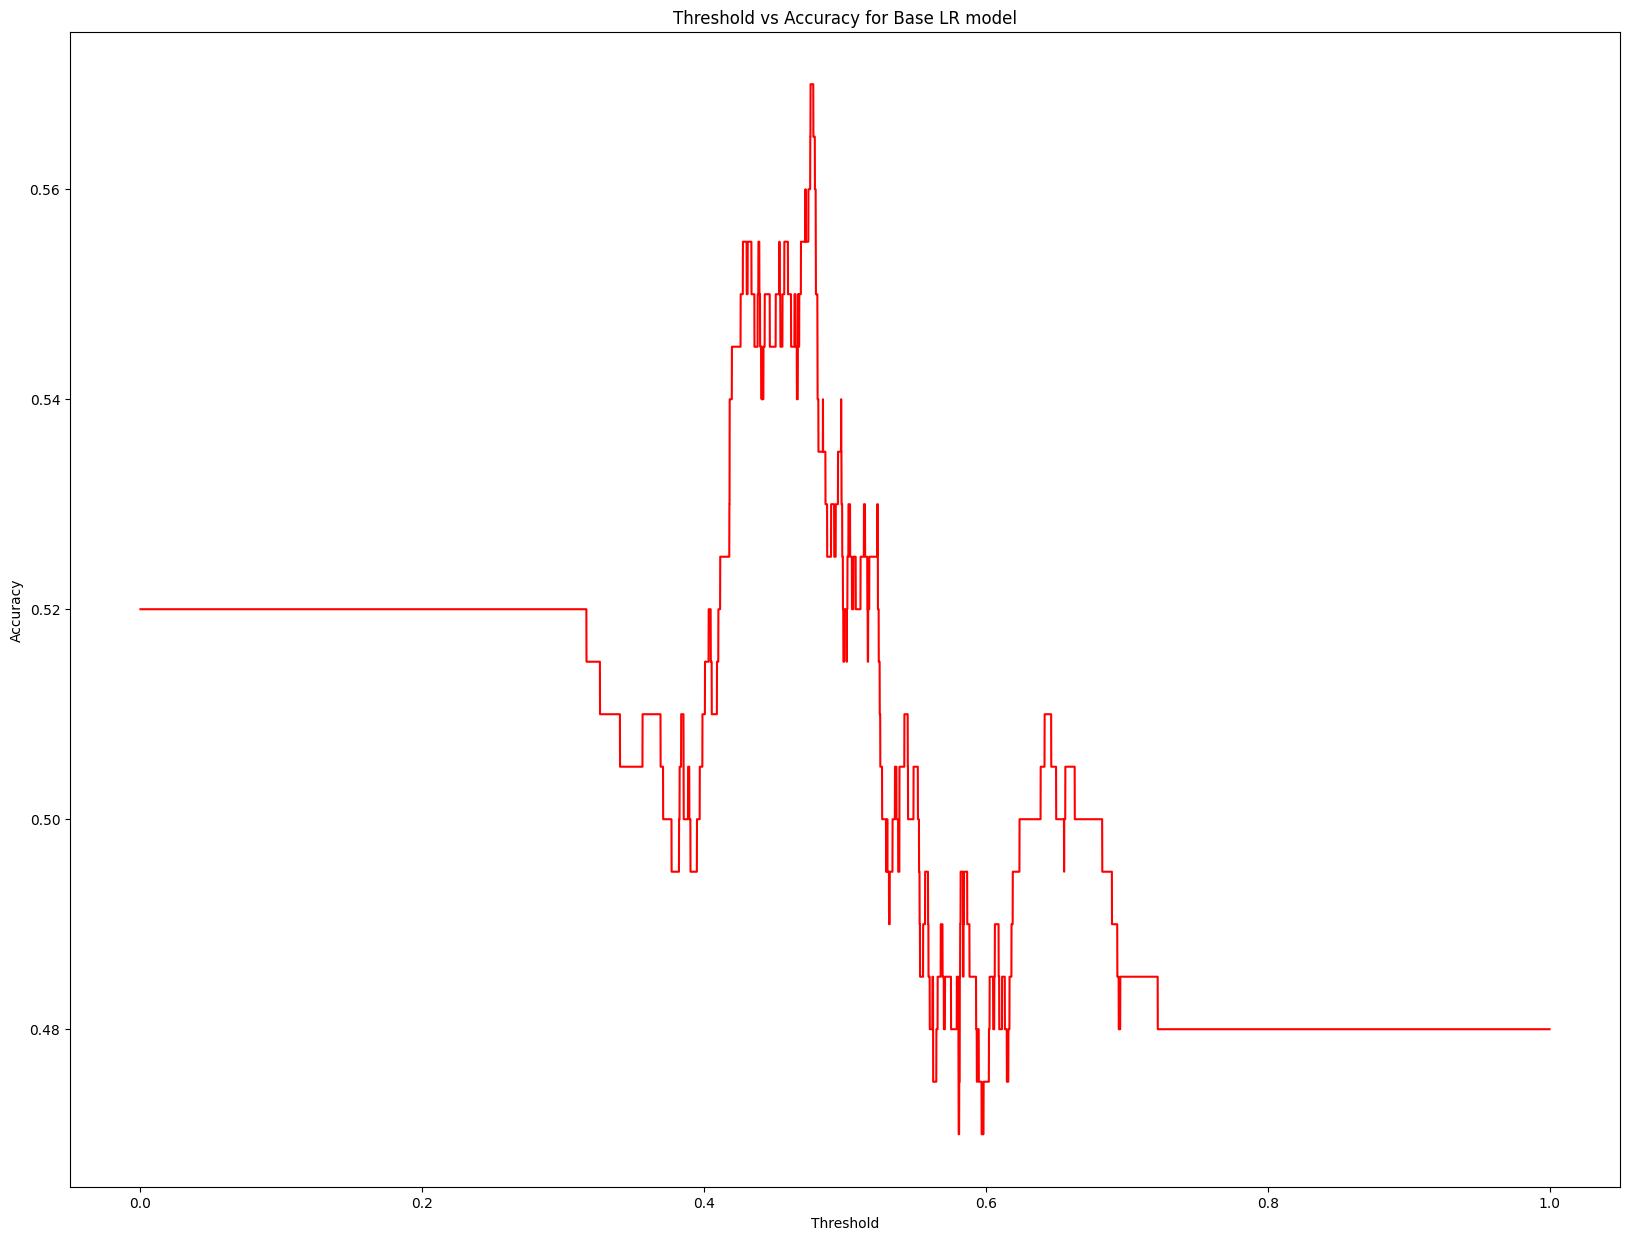

In [13]:
""" Threshold Based Log Regression """

threshold , increment = 0.0001, 0.0001
y_pred_proba = model.predict_proba(X_test)[:, 1]

thresh = []
accuracy = []
while threshold <= 1:

    y_pred_proba1 = (y_pred_proba >= threshold)
    acc = accuracy_score(y_test, y_pred_proba1)

    accuracy.append(acc)
    thresh.append(threshold)
    threshold += increment

plt.figure(figsize=(20, 15))
plt.plot(thresh, accuracy, c='r')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold vs Accuracy for Base LR model')
plt.show()

In [14]:
""" Using HyperParameter Tuning for the 1st XGBoost Model"""

xgb = XGBClassifier(
    objective='binary:logistic',
    eval='auc',
    seed=42
)

params = {

    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.001, 0.002, 0.01, 0.02, 0.1, 0.2],
    'max_depth': [i for i in range(3, 11)]
}

gcv = GridSearchCV(

    estimator=xgb,
    param_grid=params,
    n_jobs=-1,
    scoring='roc_auc'
)

gcv.fit(X_train, y_train)

print(f"The best model parameters are: {gcv.best_params_}")
print(f"The best AUC score is: {gcv.best_score_}")

The best model parameters are: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 700}
The best AUC score is: 0.5309419829024645
